# 双均线策略
本文主要介绍使用双均线策略对股票代号为600036的股票进行买入/卖出。步骤如下：
* 1.从Baostock上下载数据，清洗数据并存入本地
* 2.编写双均线策略
* 3.使用策略进行回测

### 参考：
* baostock数据的获取 http://baostock.com/baostock/index.php/A%E8%82%A1K%E7%BA%BF%E6%95%B0%E6%8D%AE
* 算法教学 (1).https://www.bilibili.com/video/BV1da4y1H7WL
* (2).https://www.bilibili.com/video/BV1i741147LS

# 1.数据预处理

In [151]:
import baostock as bs
import pandas as pd

In [152]:
class Get_data_from_baostock:
    
    def __init__(self, stock, start_date, end_date, freq, adjustflag):
        self.stock = stock
        self.start_date = start_date
        self.end_date = end_date
        self.freq = freq
        self.adjustflag = adjustflag
    
    def download_data_from_baostock(self):
        lg = bs.login()
        if str(self.stock)[0] == '6':
            stock_name = 'sh.' + str(self.stock)
        else:
            stock_name = 'sz.' + str(self.stock)
        
        if self.freq in ['d', 'w', 'm']:
            fields = "date,code,open,high,low,close,preclose,volume,amount,adjustflag,turn,tradestatus,pctChg,isST"
        else:
            fields = "date,time,code,open,high,low,close,volume,amount,adjustflag"
        
        rs = bs.query_history_k_data_plus(stock_name,
                                      fields,
                                      start_date = self.start_date, 
                                      end_date = self.end_date,
                                      frequency = str(self.freq), 
                                      adjustflag = str(self.adjustflag) # 2是前复权
                                     )
        bs.logout()
        
        df = pd.DataFrame(rs.data)
        df.columns = fields.split(',')
        
        df['open'] = [float(t) for t in df['open']]
        df['close'] = [float(t) for t in df['close']]
        df['high'] = [float(t) for t in df['high']]
        df['low'] = [float(t) for t in df['low']]  
        df['amount'] = [float(t) for t in df['amount']]
        df['volume'] = [float(t) for t in df['volume']]
        
        
        if self.freq in ['5','15','30','60']:
            df['time'] = [t[:-3] for t in df['time']] # 把毫秒去掉，否则int太长了无法转化为datatime格式
            df['time'] = pd.to_datetime(df['time'])
            df = df.loc[:, ['time','open','high','low','close','amount','volume']]
            df.rename(columns = {'time':'datetime'},inplace = True)
            df.set_index('datetime', drop=True, inplace = True) # 用时间作为index
        elif self.freq in ['d', 'w', 'm']:
            df = df.loc[:, ['date','open','high','low','close','amount','volume']]
            df['date'] = pd.to_datetime(df['date'])
            df.rename(columns = {'date':'datetime'},inplace = True)
            df.set_index('datetime', drop=True, inplace = True) # 用时间作为index
        else:
            print('k线时间输入错误')
            
        self.df = df
        return df
    
    def save_baostock_data_to_local(self,address):
        self.df.to_csv(address + '%s_%s.csv' % (self.stock,self.freq))
        print('文件已保存到'+ address + '%s_%s.csv' % (self.stock,self.freq))
        

In [160]:
GD = Get_data_from_baostock('603019','2022-01-01','2023-01-01','d','2')
data = GD.download_data_from_baostock()
address = 'E:/data/stock_data/'
GD.save_baostock_data_to_local(address)

login success!
logout success!
文件已保存到E:/data/stock_data/603019_d.csv


In [161]:
data.head()

,open,high,low,close,amount,volume
datetime,,,,,,
2022-01-04,27.495485,28.568674,27.475611,28.548800,9.918807e+08,35033571.0
2022-01-05,28.389809,28.807160,28.320251,28.399746,7.410378e+08,25797381.0
2022-01-06,28.240755,28.916466,28.012206,28.737602,6.856710e+08,23855766.0
2022-01-07,28.807160,28.986025,28.022143,28.051953,5.365614e+08,18751424.0
2022-01-10,28.051953,30.784609,28.032080,30.267889,2.346896e+09,78006464.0


# 2.双均线策略

In [162]:
data = data.loc[:,['open','close','high','low']]
data['ma5'] = data['close'].rolling(5).mean()
data['ma30'] = data['close'].rolling(30).mean()  
# 用rolling构建ma
data.tail(10)

,open,close,high,low,ma5,ma30
datetime,,,,,,
2022-12-19,22.72,22.52,22.92,22.35,22.978,23.992000
2022-12-20,22.58,22.18,22.75,22.07,22.796,23.898000
2022-12-21,22.19,22.01,22.28,21.83,22.552,23.819667
2022-12-22,22.20,21.93,22.24,21.78,22.272,23.743667
2022-12-23,21.90,21.88,22.00,21.67,22.104,23.666667
2022-12-26,21.89,22.10,22.28,21.88,22.020,23.592667
2022-12-27,22.18,22.26,22.27,21.92,22.036,23.509667
2022-12-28,22.15,21.86,22.15,21.82,22.006,23.420333
2022-12-29,21.74,21.89,22.15,21.72,21.998,23.300000


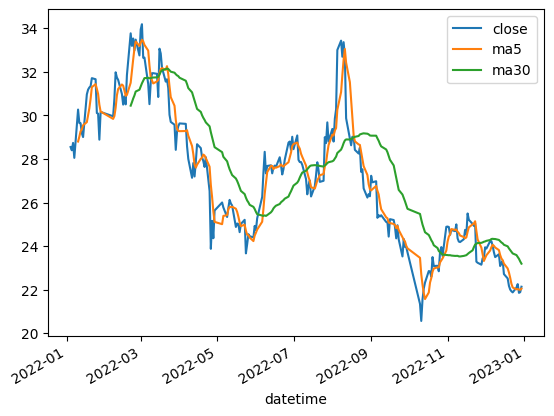

In [163]:
import matplotlib.pyplot as plt
data.loc[:,['close','ma5','ma30']].plot()
plt.show()

In [164]:
data = data.dropna()

In [165]:
# 计算金叉和死叉日期
# 以金叉为例子：金叉为ma5上穿ma30,data['ma5']<data['ma30']会有一段类似TTTTFFFFTTTT，
# 而data['ma5']>data['ma30']会有一段对应FFFFTTTTFFFF,此时把后面的序列shift1位，与第一序列相同的位置F即为金叉，T即为死叉
# TTTTFFFFTTTT
#  FFFFTTTTFFFF
sr1 = data['ma5'] < data['ma30']
sr2 = data['ma5'] >= data['ma30']
death_cross =  data[sr1 & sr2.shift(1)].index # &两个同时T才会是T,所以这个选的是死叉
death_cross

DatetimeIndex(['2022-03-10', '2022-03-21', '2022-03-23', '2022-07-12',
               '2022-08-19', '2022-11-28'],
              dtype='datetime64[ns]', name='datetime', freq=None)

In [166]:
golden_cross = data[~(sr1| sr2.shift(1))].index # or两个同时F才会是F,所以这个选的是金叉
golden_cross

DatetimeIndex(['2022-02-21', '2022-03-16', '2022-03-22', '2022-06-07',
               '2022-07-27', '2022-10-31'],
              dtype='datetime64[ns]', name='datetime', freq=None)